# Predicting Employee Attrition using IBM Dataset

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

py_file_location = "/content/drive/Shareddrives/STUDENT-capstone-wi23/teamhranalytics/utilities/adspy_shared_utilities.py"
sys.path.append(os.path.abspath(py_file_location))


random_state = 42

# Functions

In [2]:
# https://www.kaggle.com/code/faressayah/decision-trees-random-forest-for-beginners?scriptVersionId=117930749&cellId=13
from sklearn.metrics import confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [3]:
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.offline as py

def model_performance_plot(model) : 
        
    #plot roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : ",
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    #subplots
    fig = tls.make_subplots(rows=1, cols=2, print_grid=False, 
                        subplot_titles=('ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve'))
    

    fig.append_trace(trace3,1,1)
    fig.append_trace(trace4,1,1)
    fig.append_trace(trace5,1,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance</b><br>'+str(model),
                        autosize = True, height = 500,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis"].update(dict(title = "precision"), range = [0,1.05])
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

In [4]:
def shap_force(clf, clf_step_name, index, 
               X_train_df, y_train,
               explainer, shap_vals):
  
    """Takes in a fitted classifier Pipeline, the name of the classifier step,
        the X training DataFrame, the y train array, a shap explainer, and the
        shap values to print the ground truth and predicted label and display
        the shap force plot for the record specified by index.
    Args:
        clf (estimator): An sklearn Pipeline with a fitted classifier as the final step.
        clf_step_name (str): The name given to the classifier step of the pipe.
        X_train_df (DataFrame): A Pandas DataFrame from the train-test-split
            used to train the classifier, with column names corresponding to
            the feature names.
        y_train (series or array): Subset of y data used for training.
        index (int): The index of the observation of interest.
        explainer (shap explainer): A fitted shap.TreeExplainer object.
        shap_vals (array): The array of shap values.
    Returns:
        Figure: Shap force plot showing the breakdown of how the model made
            its prediction for the specified record in the training set.
    """    
    
    
    ## Store model prediction and ground truth label
    pred = clf.named_steps[clf_step_name].predict(X_train_df.iloc[index,:])
    true_label = y_train.iloc[index]
    
    
    ## Assess accuracy of prediction
    if true_label == pred:
        accurate = 'Correct!'
    else:
        accurate = 'Incorrect'
    
    
    ## Print output that checks model's prediction against true label
    print('***'*12)
    # Print ground truth label for row at index
    print(f'Ground Truth Label: {true_label}')
    print()
    # Print model prediction for row at index
    print(f'Model Prediction:  {pred} -- {accurate}')
    print('***'*12)
    print()
    
    
    ## Plot the prediction's explanation
    fig = shap.force_plot(explainer.expected_value,
                              shap_vals[index,:],
                              X_train_df.iloc[index,:])
    
    
    return fig

In [5]:
def catconsep(df):
  # https://www.kaggle.com/code/utkarshgaikwad1994/hr-attrition-utkarsh-gaikwad?scriptVersionId=117850320&cellId=22
    cat, con = [], []
    for i in df.columns:
        if df[i].dtype=='object':
            cat.append(i)
        else:
            con.append(i)
    return cat, con

# EDA of IBM Dataset

In [6]:
ibm_data = pd.read_csv('/content/drive/Shareddrives/STUDENT-capstone-wi23/teamhranalytics/data/wa_fn-usec_-hr-employee-attrition.csv')

In [7]:
ibm_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [8]:
ibm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [9]:
cat,con = catconsep(ibm_data)

In [10]:
ibm_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


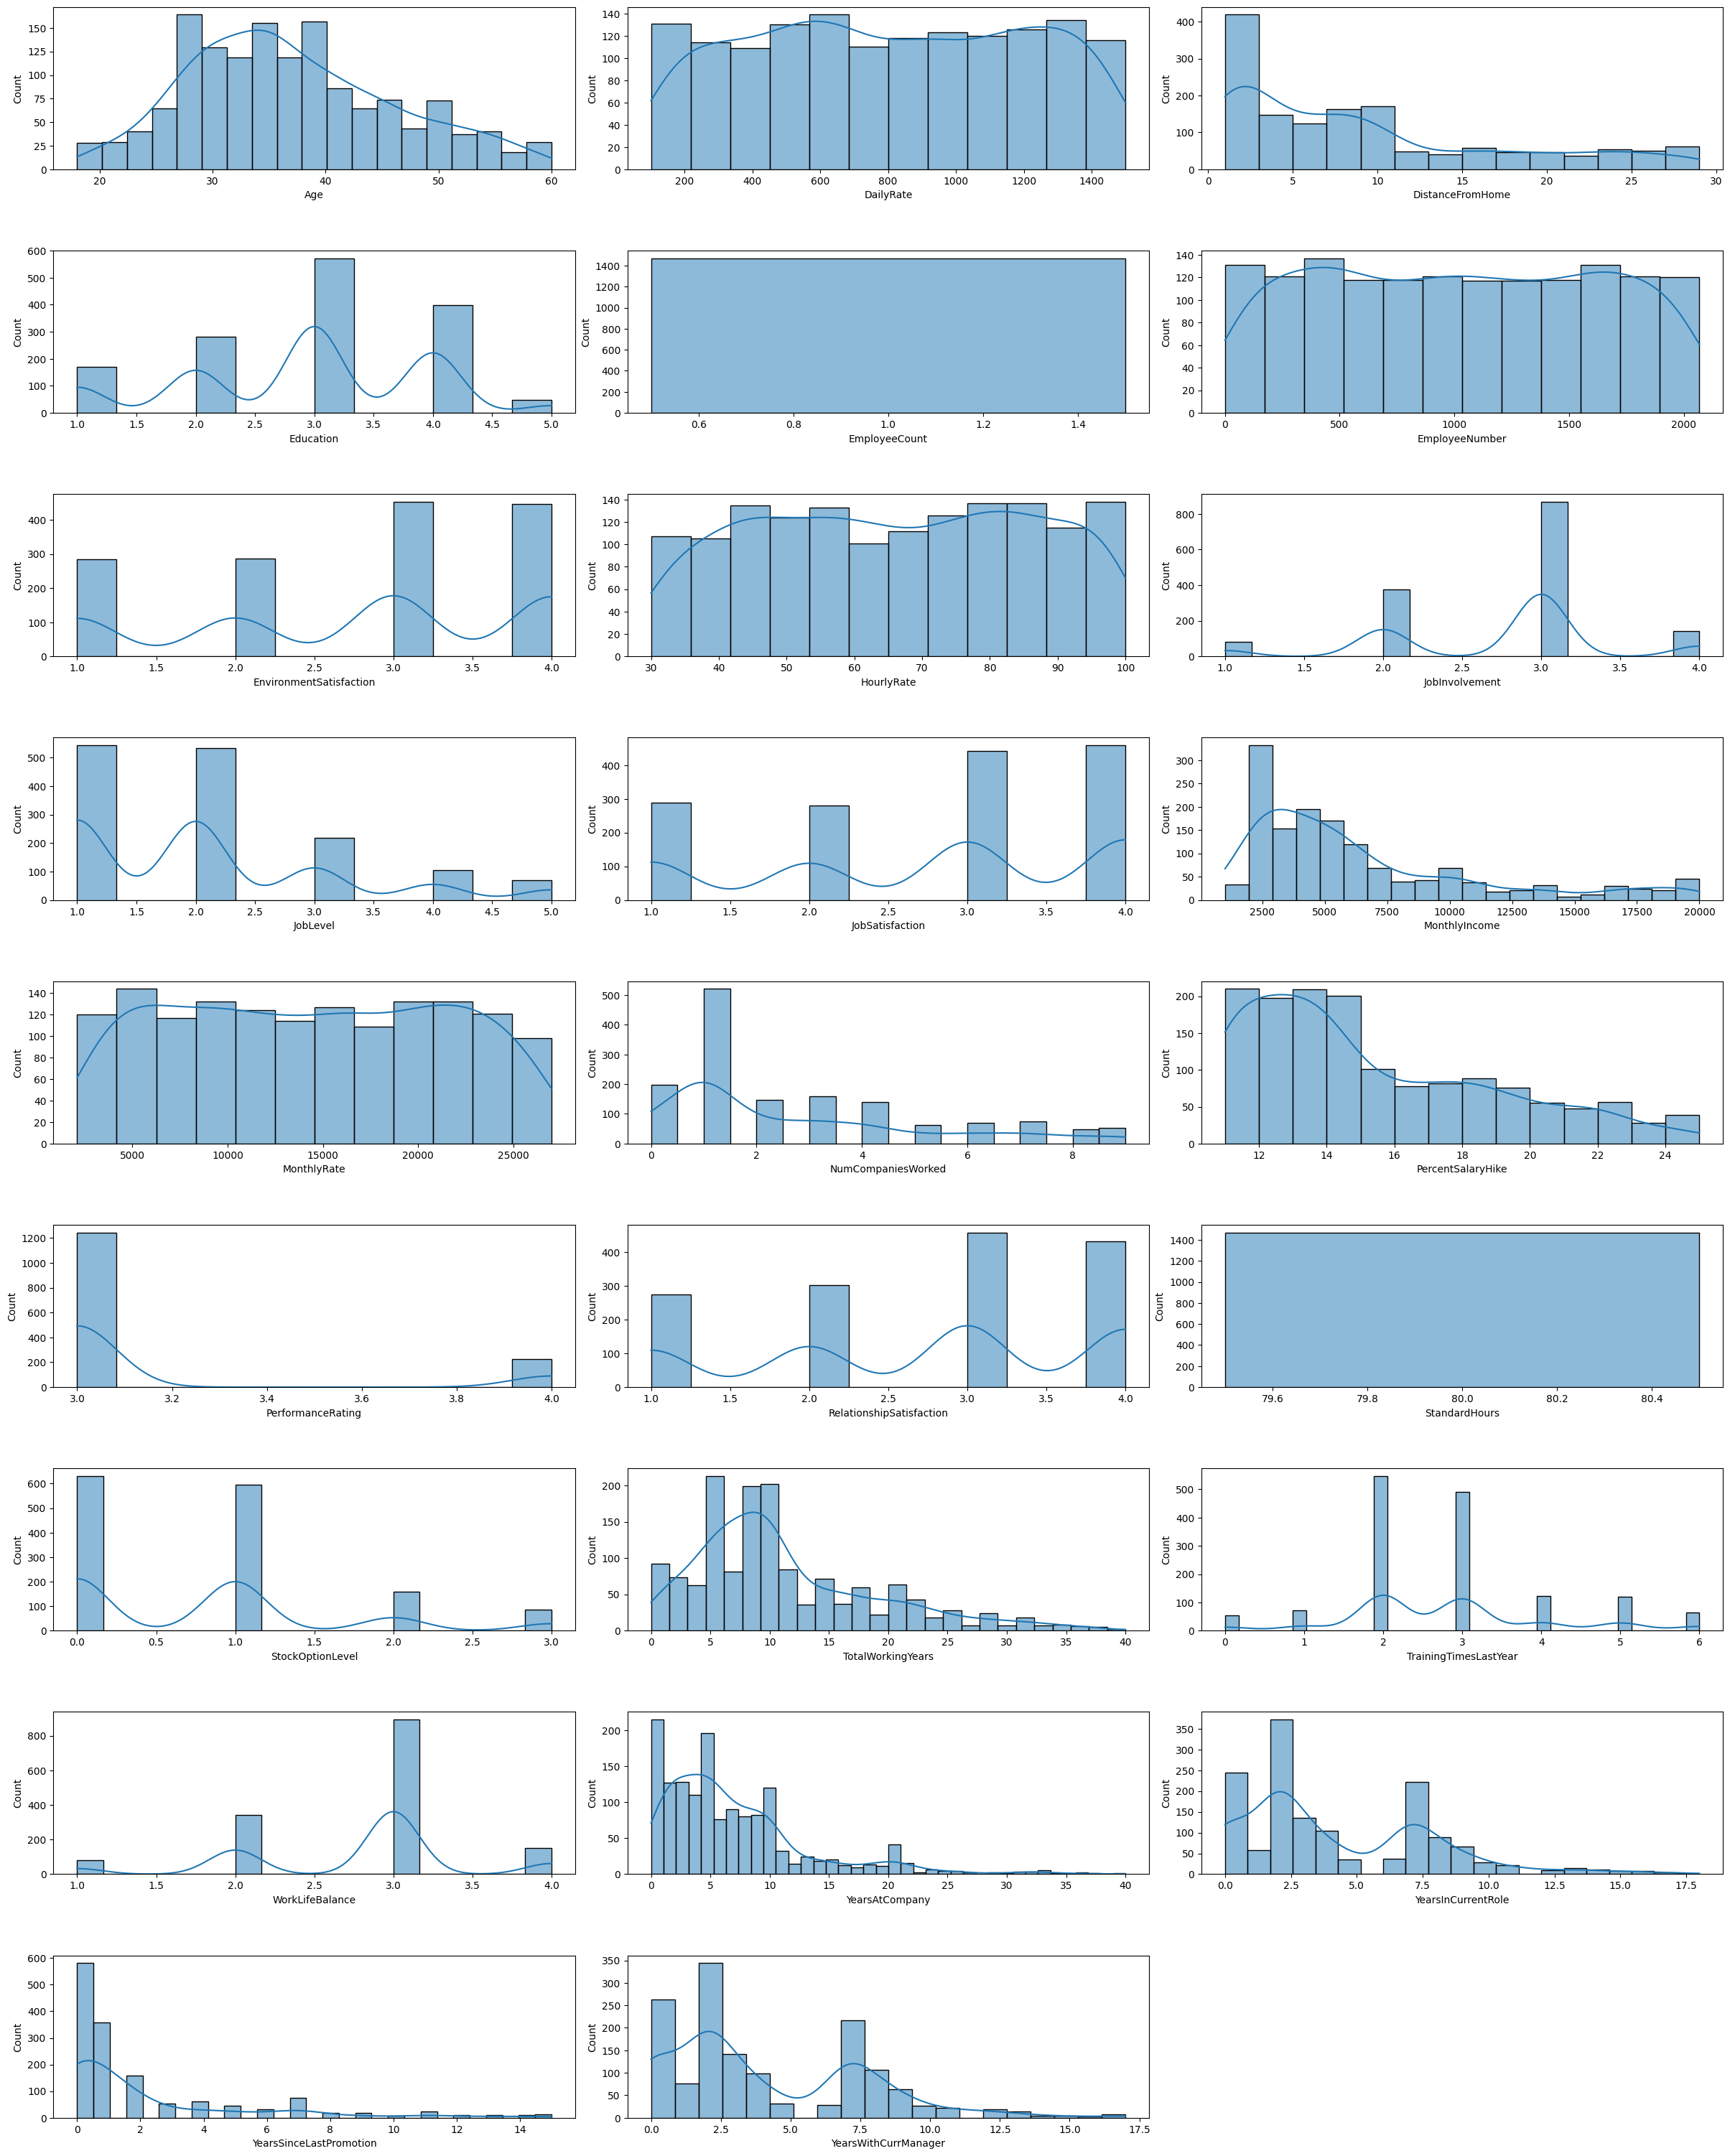

In [11]:
plt.figure(figsize=(30,30))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.1)
x = 1

for i in con:
    plt.subplot(9,3,x)
    x = x+1
    sns.histplot(data = ibm_data, x = i, kde=True)
plt.show()

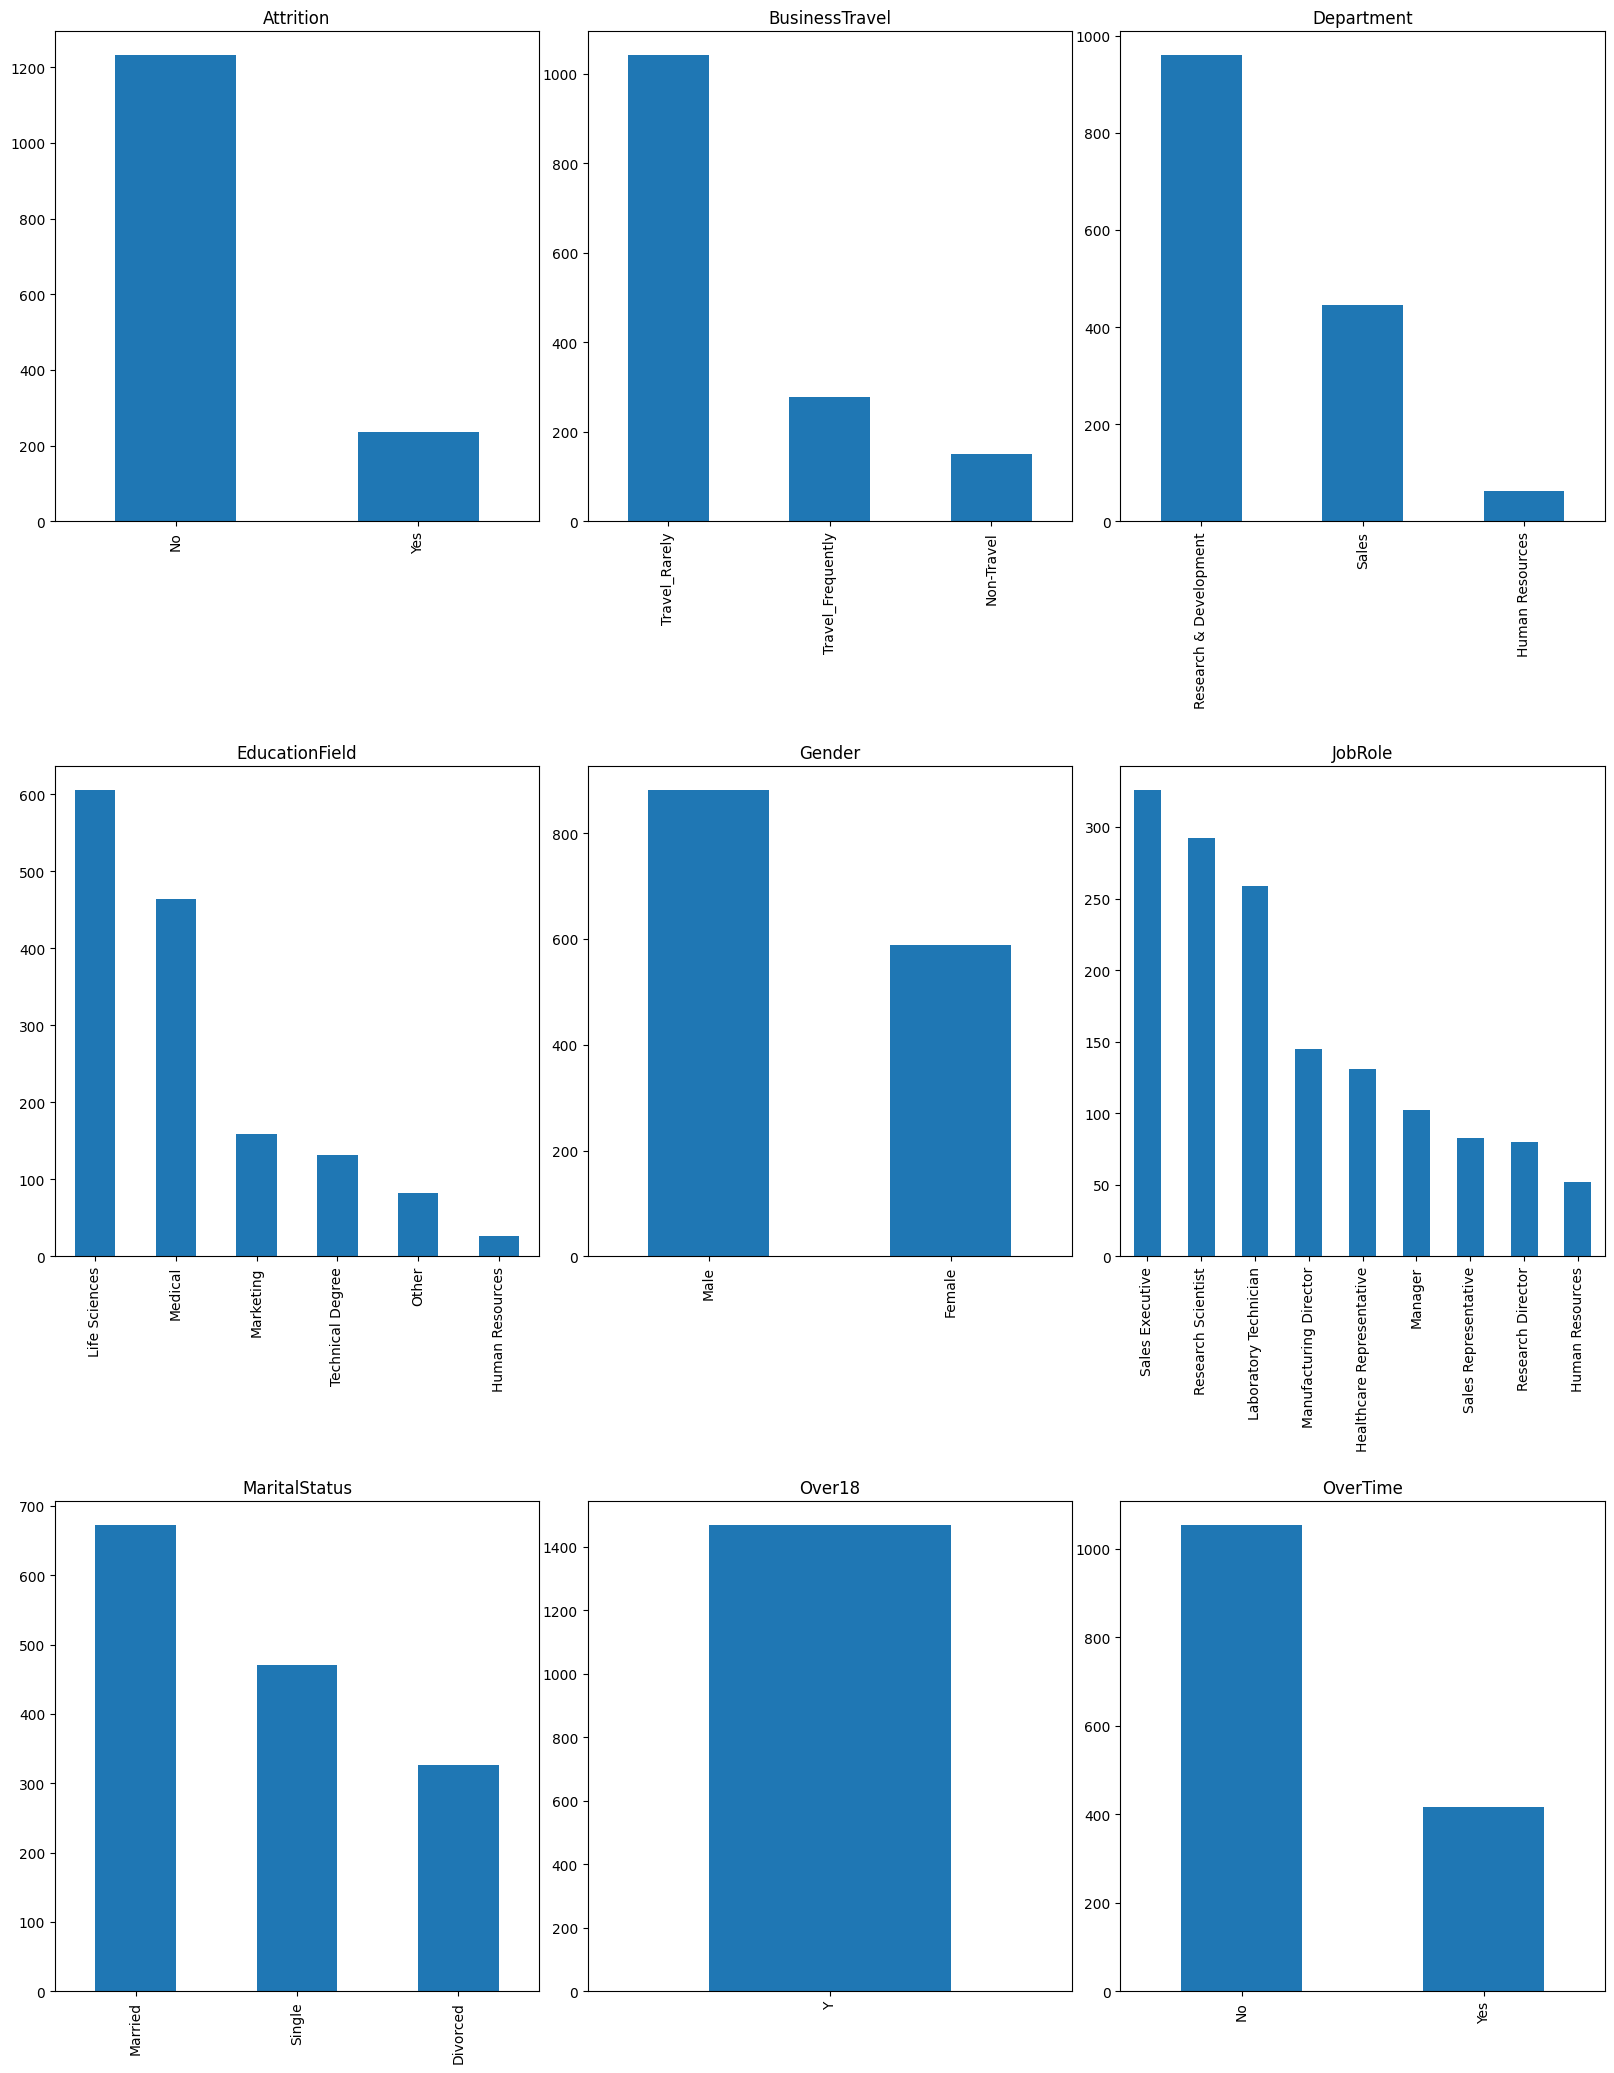

In [12]:
plt.figure(figsize=(20,20))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.1)
for i in cat:
    plt.subplot(3,3,x)
    x = x+1
    ibm_data[i].value_counts().plot(kind='bar')
    plt.title(i)
plt.show()

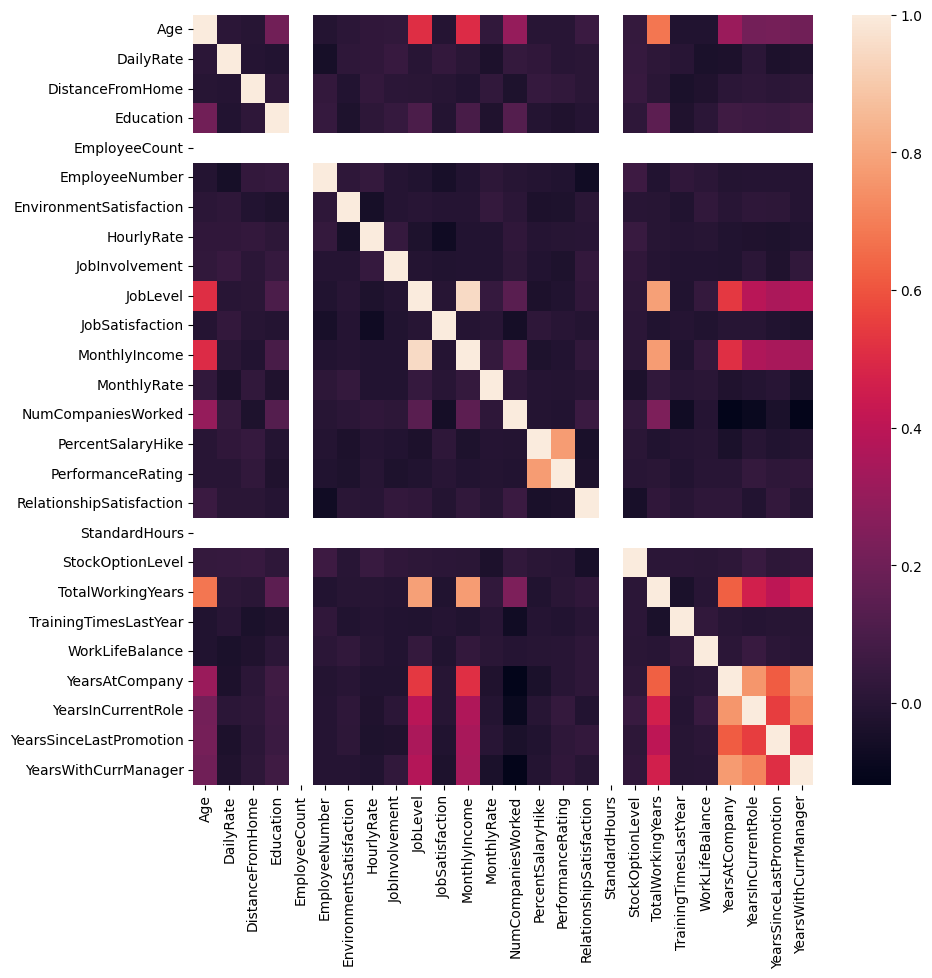

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(ibm_data.corr())
plt.show()

## Collinear Feature Removal

By removing collinear features, we can improve the performance and interpretability of the model by reducing the noise in the data and increasing the relevance of the predictor variables.

In [14]:
from sklearn.preprocessing import LabelEncoder

df = ibm_data
le = LabelEncoder()
# target variable
y = pd.DataFrame(le.fit_transform(df['Attrition']),columns=df[['Attrition']].columns)

# features encoded
x_cat = pd.get_dummies(df[cat].drop(columns=['Attrition','Over18']))
x_con = df[con].drop(columns= ['EmployeeCount', 'EmployeeNumber', 'StandardHours'])
X = x_con.join(x_cat)

df_encoded = pd.concat([X,y], axis = 1)

In [15]:
df_encoded.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,41,1102,1,2,2,94,3,2,4,5993,...,0,0,1,0,0,0,1,0,1,1
1,49,279,8,1,3,61,2,2,2,5130,...,0,1,0,0,0,1,0,1,0,0
2,37,1373,2,2,4,92,2,1,3,2090,...,0,0,0,0,0,0,1,0,1,1
3,33,1392,3,4,4,56,3,1,3,2909,...,0,1,0,0,0,1,0,0,1,0
4,27,591,2,1,1,40,3,1,2,3468,...,0,0,0,0,0,1,0,1,0,0


In [16]:
# https://www.kaggle.com/code/vincentlugat/ibm-attrition-analysis-and-prediction?scriptVersionId=10006574&cellId=36

# Threshold for removing correlated variables
threshold = 0.8 #lowering the threshold to 0.7 from example 

# Absolute value correlation matrix
corr_matrix = df_encoded.corr().abs()
corr_matrix.head()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove :' % (len(to_drop)))

X = X.drop(columns = to_drop)

to_drop

There are 6 columns to remove :


['MonthlyIncome',
 'Department_Sales',
 'Gender_Male',
 'JobRole_Human Resources',
 'JobRole_Sales Executive',
 'OverTime_Yes']

# Decision Tree Classifier

## Preprocessing 

In [17]:
len(X.columns)

45

## Train, Validation, Test Sets for Decision Tree

In [18]:
from sklearn.model_selection import train_test_split
# https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c

# 80:10:10
train_size=0.8
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y,train_size=0.8)
# X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# test_size = 0.5
# X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
# print(X_valid.shape),print(y_valid.shape)
print(X_test.shape),print(y_test.shape)

(1176, 45)
(1176, 1)
(294, 45)
(294, 1)


(None, None)

In [19]:
X_train.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyRate,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No
525,24,693,3,2,1,65,3,2,3,24785,...,0,0,0,0,0,0,0,0,1,1
202,34,878,10,4,4,43,3,1,3,5972,...,0,0,0,0,1,0,1,0,0,0
959,40,523,2,3,3,98,3,2,4,22455,...,0,0,0,0,1,0,0,0,1,1
1454,45,374,20,3,4,50,3,2,3,23333,...,0,0,0,0,0,0,0,0,1,1
774,55,444,2,1,3,40,2,4,1,17323,...,0,1,0,0,0,0,0,0,1,1


## Feature Selection


In [20]:
!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
# # Going to conduct various wrapper methods for feature selection on Decision Tree and SVM

# # forward selection method
# # http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/#sequentialfeatureselector
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS 
# from sklearn.tree import DecisionTreeClassifier


# #Define Sequential Forward Selection (sfs)
# sfs = SFS(DecisionTreeClassifier(),
#            k_features=(40,51),
#           #  forward=True,
#            floating=False,
#            scoring = 'roc_auc'
#            )
# #Use SFS to select the top 5 features 
# sfs.fit(X_train, y_train)

# #Create a dataframe for the SFS results 
# df_SFS_results = pd.DataFrame(sfs.subsets_).transpose()
# df_SFS_results

## Model Tuning

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score

In [23]:
# Decision Tree Classifier before any tuning
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

print_score(dt, X_train, y_train, X_test, y_test, train=True)
print_score(dt, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    986.0  190.0       1.0     1176.0        1176.0
_______________________________________________
Confusion Matrix: 
 [[986   0]
 [  0 190]]

Test Result:
Accuracy Score: 78.91%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.883817   0.358491  0.789116    0.621154      0.799837
recall       0.862348   0.404255  0.789116    0.633302      0.789116
f1-score     0.872951   0.380000  0.789116    0.626475      0.794146
support    247.000000  47.000000  0.789116  294.000000    294.000000
_______________________________________________
Conf

In [24]:
# Decision Tree Grid Search

dt = DecisionTreeClassifier()

#Parameters to run through GridSearch
param_grid = {'random_state' : [random_state],
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':list(range(1,20)),
    'min_samples_split':list(range(2,5)),
    'min_samples_leaf':list(range(1,5))
            }

#Run GridSearch
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)

#Print out best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}
Best score:  0.8469347277316984


In [25]:
#Best Decision Tree Model used on validation set

dt_final = grid_search.best_estimator_

rf_cross_val = cross_validate(dt_final, X_train, y_train, cv=5, scoring = ('roc_auc','accuracy','f1','precision','recall'))

#The roc_auc, accuracy, and f-score following 5-fold cross-validation and its standard deviation
print("Mean scores - Decision Tree Best Model; ", 'roc_auc:{:.3f}'.format(np.mean(rf_cross_val['test_roc_auc'])), 'accuracy:{:.3f}'.format(np.mean(rf_cross_val['test_accuracy'])),'f-score:{:.3f}'.format(np.mean(rf_cross_val['test_f1'])))
print("St. Dev. of Scores - Decision Tree Best Model: ",   'roc_auc:{:.3f}'.format(np.std(rf_cross_val['test_roc_auc'])), 'accuracy:{:.3f}'.format(np.std(rf_cross_val['test_accuracy'])),'f-score:{:.3f}'.format(np.std(rf_cross_val['test_f1'])))

dt_final.fit(X_train,y_train)

print_score(dt_final, X_train, y_train, X_test, y_test, train=True)
print_score(dt_final, X_train, y_train, X_test, y_test, train=False)

Mean scores - Decision Tree Best Model;  roc_auc:0.742 accuracy:0.847 f-score:0.362
St. Dev. of Scores - Decision Tree Best Model:  roc_auc:0.054 accuracy:0.013 f-score:0.020
Train Result:
Accuracy Score: 85.46%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.874885    0.606742  0.854592     0.740813      0.831563
recall       0.964503    0.284211  0.854592     0.624357      0.854592
f1-score     0.917511    0.387097  0.854592     0.652304      0.831815
support    986.000000  190.000000  0.854592  1176.000000   1176.000000
_______________________________________________
Confusion Matrix: 
 [[951  35]
 [136  54]]

Test Result:
Accuracy Score: 81.63%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.864151   0.379310  0.816327    0.621731      0.786642
recall       0.927126   0

## Confusion Matrix of Tuned Model Predictions of test set

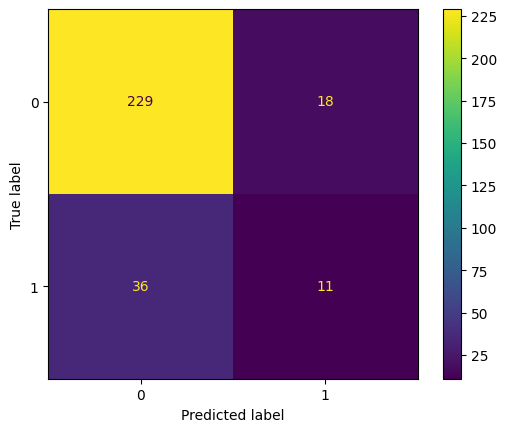

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = dt_final.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

## Vizualiation of Decision Tree

In [27]:
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

features = list(X_test.columns)
# features.remove("Attrition")

In [28]:
#utility from SIADS 542: Supervised Learning
%cd /content/drive/Shareddrives/STUDENT-capstone-wi23/teamhranalytics/utilities
from adspy_shared_utilities import plot_decision_tree 

/content/drive/Shareddrives/STUDENT-capstone-wi23/teamhranalytics/utilities


In [29]:
target_values = ['0','1']

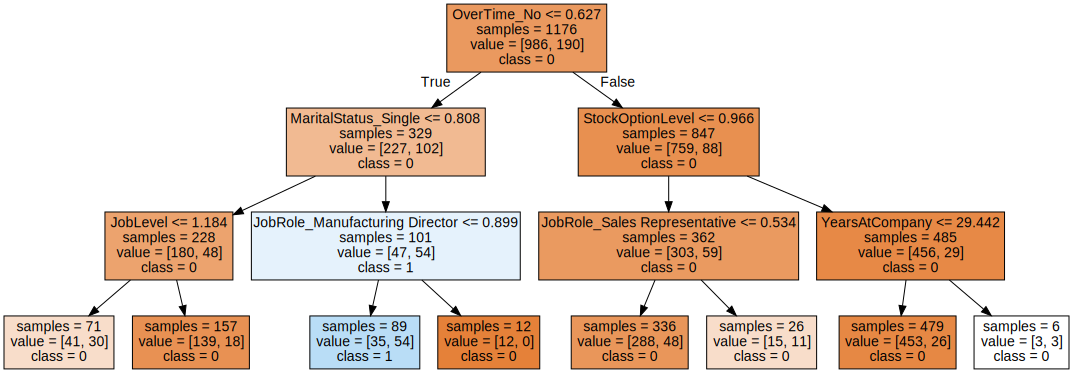

In [30]:
plot_decision_tree(dt_final, features, target_values)

## SHAP Score for DT

In [31]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
explainer = shap.TreeExplainer(dt_final)
shap_values = explainer.shap_values(X_test)
# shap_values

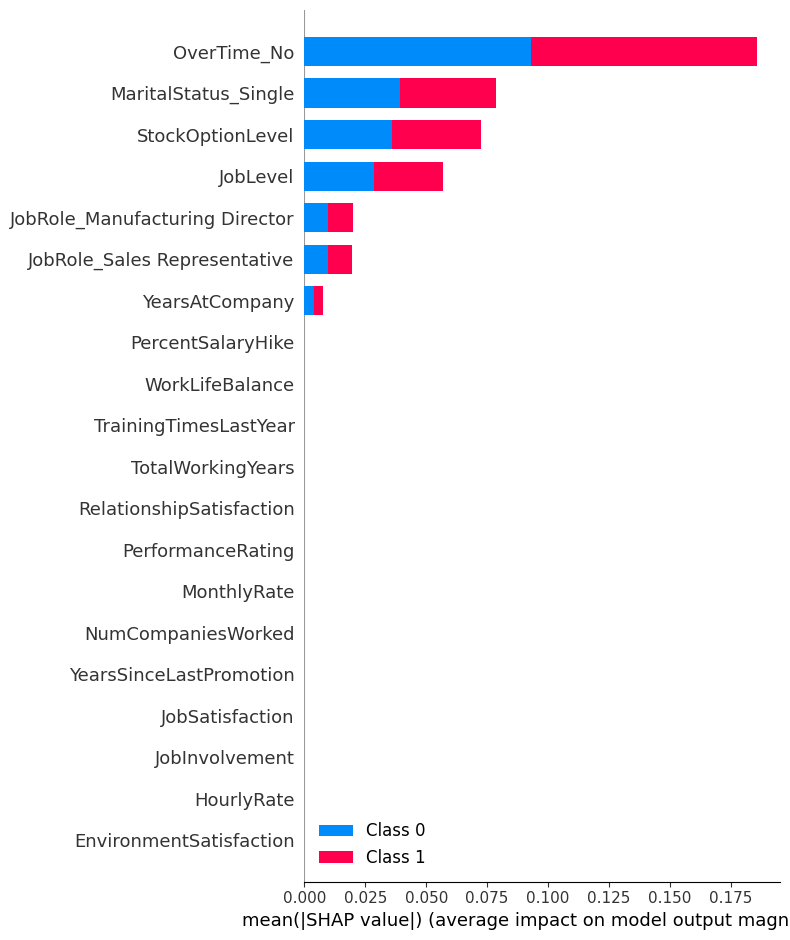

In [33]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

In [34]:
np.where(y_pred==1)

(array([  9,  11,  15,  21,  25,  41,  67,  79,  85,  87, 120, 123, 126,
        130, 143, 172, 183, 186, 200, 220, 229, 233, 239, 242, 243, 256,
        258, 286, 288]),)

In [35]:
print("test attrition actual", y_test.iloc[1])
print("test attrition prediction", y_pred[1])
# Take note of FN and what contributed to the predicton

test attrition actual Attrition    0
Name: 18, dtype: int64
test attrition prediction 0


In [36]:
#Force Plot for a single observation for a single class 1
shap.initjs()
shap.force_plot(explainer.expected_value[1],
shap_values[1][0,:], X_test.iloc[0,:])

In [37]:
shap.initjs()
shap.force_plot(explainer.expected_value[1],
shap_values[1][1,:], X_test.iloc[1,:])

This observation:

*   probability of this obersvation attrition 1 (second matrix in list of shap_vales)

[classification example using SHAP force plot](https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)


# Random Forest

In [38]:
from scipy.stats import randint
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [39]:
clf = RandomForestClassifier(random_state=random_state) #without tuning
clf.fit(X_train, y_train.values.ravel())

print_score(clf, X_train, y_train, X_test, y_test, train=True)
print_score(clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    986.0  190.0       1.0     1176.0        1176.0
_______________________________________________
Confusion Matrix: 
 [[986   0]
 [  0 190]]

Test Result:
Accuracy Score: 86.05%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.862676   0.800000  0.860544    0.831338      0.852656
recall       0.991903   0.170213  0.860544    0.581058      0.860544
f1-score     0.922787   0.280702  0.860544    0.601744      0.820141
support    247.000000  47.000000  0.860544  294.000000    294.000000
_______________________________________________
Conf

In [40]:
clf = RandomForestClassifier(random_state=random_state)

param_dist = {
    "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "max_features": list(range(1,12)),
    "min_samples_split": [2, 5, 10],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
    "n_estimators": [200, 400, 600]
}

rsh = HalvingRandomSearchCV(
    estimator=clf, param_distributions=param_dist, factor=2, random_state=random_state
)
rsh.fit(X_train, y_train.values.ravel())
rsh.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'max_features': 6,
 'max_depth': 80,
 'criterion': 'entropy',
 'bootstrap': True}

In [41]:
rfc = rsh.best_estimator_
rfc.fit(X_train,y_train.values.ravel())

RandomForestClassifier(criterion='entropy', max_depth=80, max_features=6,
                       min_samples_split=5, n_estimators=600, random_state=42)

In [42]:
print_score(rfc, X_train, y_train, X_test, y_test, train=True)
print_score(rfc, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 99.40%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.992951    1.000000  0.994048     0.996475      0.994090
recall       1.000000    0.963158  0.994048     0.981579      0.994048
f1-score     0.996463    0.981233  0.994048     0.988848      0.994002
support    986.000000  190.000000  0.994048  1176.000000   1176.000000
_______________________________________________
Confusion Matrix: 
 [[986   0]
 [  7 183]]

Test Result:
Accuracy Score: 86.39%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.863158   0.888889  0.863946    0.876023      0.867271
recall       0.995951   0.170213  0.863946    0.583082      0.863946
f1-score     0.924812   0.285714  0.863946    0.605263      0.822643
support    247.000000  47.000000  0.863946  294.000000    294.

In [43]:
rfexplainer = shap.TreeExplainer(rfc)
rfshap_values = rfexplainer.shap_values(X_test)

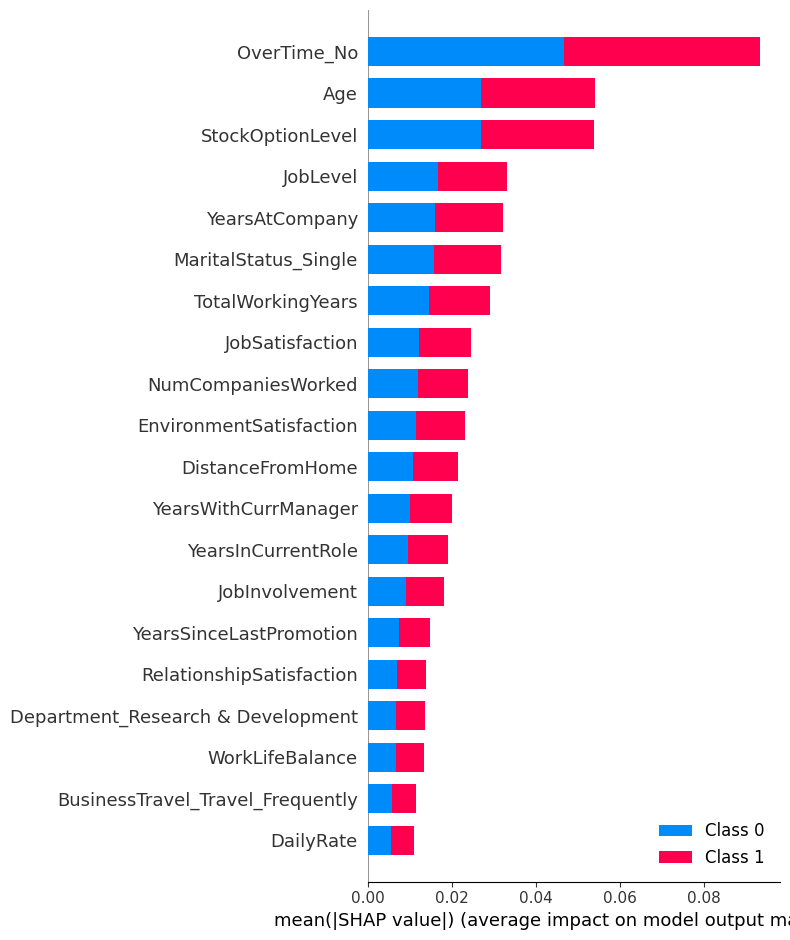

In [44]:
shap.initjs()
shap.summary_plot(rfshap_values, X_test)

(array([ 25,  67,  91, 105, 130, 158, 186, 286, 288]),)

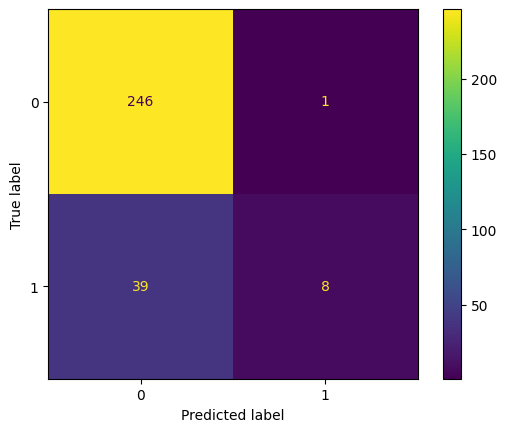

In [45]:
y_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()
np.where(y_pred==1)

In [46]:
print("test attrition actual", y_test.iloc[16])
print("test attrition prediction", y_pred[16])

test attrition actual Attrition    1
Name: 1291, dtype: int64
test attrition prediction 0


In [47]:
#Force Plot for a single observation for a single class 1
shap.initjs()
shap.force_plot(rfexplainer.expected_value[1],
rfshap_values[1][16,:], X_test.iloc[16,:])

In [48]:
shap.initjs()
shap.force_plot(explainer.expected_value[1],
shap_values[1][3,:], X_test.iloc[3,:])

# SVM Classifier

## Preprocessing

## Train and Test Split

In [49]:
df_encoded.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,41,1102,1,2,2,94,3,2,4,5993,...,0,0,1,0,0,0,1,0,1,1
1,49,279,8,1,3,61,2,2,2,5130,...,0,1,0,0,0,1,0,1,0,0
2,37,1373,2,2,4,92,2,1,3,2090,...,0,0,0,0,0,0,1,0,1,1
3,33,1392,3,4,4,56,3,1,3,2909,...,0,1,0,0,0,1,0,0,1,0
4,27,591,2,1,1,40,3,1,2,3468,...,0,0,0,0,0,1,0,1,0,0


In [50]:
df_svm = ibm_data
le = LabelEncoder()
# target variable
y = pd.DataFrame(le.fit_transform(df_svm['Attrition']),columns=df_svm[['Attrition']].columns)

# features encoded
x_cat = pd.get_dummies(df_svm[cat].drop(columns=['Attrition','Over18']))
x_con = df_svm[con].drop(columns= ['EmployeeCount', 'EmployeeNumber', 'StandardHours'])
X = x_con.join(x_cat)

df_encoded_svm = pd.concat([X,y], axis = 1)

In [51]:
# Min-Max Scale continuous feature
from sklearn.preprocessing import MinMaxScaler,StandardScaler
features = ['Age','DailyRate', 'DistanceFromHome','HourlyRate','MonthlyIncome','MonthlyRate','PercentSalaryHike','TotalWorkingYears',
 'TrainingTimesLastYear','YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
scaler = StandardScaler()
df_encoded_svm[features] = scaler.fit_transform(df_encoded_svm[features])

In [52]:
# https://www.kaggle.com/code/vincentlugat/ibm-attrition-analysis-and-prediction?scriptVersionId=10006574&cellId=36

# Threshold for removing correlated variables
threshold = 0.8 #lowering the threshold to 0.7 from example 

# Absolute value correlation matrix
corr_matrix = df_encoded_svm.corr().abs()
corr_matrix.head()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove :' % (len(to_drop)))

df_svm = df_encoded_svm.drop(columns = to_drop)

to_drop

There are 6 columns to remove :


['MonthlyIncome',
 'Department_Sales',
 'Gender_Male',
 'JobRole_Human Resources',
 'JobRole_Sales Executive',
 'OverTime_Yes']

In [53]:
X = df_svm.drop(columns = ['Attrition'])
y = df_svm['Attrition']

In [54]:
from sklearn.model_selection import train_test_split
# https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c

# 80:10:10
train_size=0.8
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y,train_size=0.8)
# X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# test_size = 0.5
# X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
# print(X_valid.shape),print(y_valid.shape)
print(X_test.shape),print(y_test.shape)

(1176, 45)
(1176,)
(294, 45)
(294,)


(None, None)

## Model Tuning

In [55]:
from sklearn.svm import SVC


svm = SVC(random_state = random_state) #svm model before any tuning
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)

print("\nAccuracy Of SVM For The Given Dataset : ", accuracy)


Accuracy Of SVM For The Given Dataset :  0.8469387755102041


In [56]:
#SVM Grid Search

svm = SVC()

#Parameters to run through GridSearch
param_grid = {'C':[0.1,1,100],
              'kernel':['rbf'],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'random_state':[random_state]}

#Run GridSearch
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring = 'accuracy')
grid_search.fit(X_train,y_train)

#Print out best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf', 'random_state': 42}
Best score:  0.8775477821853588


In [57]:
svm_final = grid_search.best_estimator_
svm_final.fit(X_train,y_train)
y_pred = svm_final.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)

print("\nAccuracy Of SVM For The Given Dataset : ", accuracy)


Accuracy Of SVM For The Given Dataset :  0.891156462585034


## SHAP SVM

In [58]:
X_test.iloc[:10,:]

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyRate,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No
992,0.227347,1.692023,1.950552,2,3,0.251388,3,3,3,-1.526851,...,0,0,0,0,0,0,0,1,0,1
226,0.008343,-1.198611,-0.640727,4,1,-1.224807,3,1,4,-1.654744,...,0,0,0,0,0,1,1,0,0,1
1014,-0.648668,-1.538248,-0.147150,5,1,1.333932,3,4,2,-0.768211,...,0,0,0,1,0,0,0,0,1,1
1077,-0.867672,-1.434125,-1.010909,4,1,1.678377,2,1,1,-0.947963,...,0,0,0,0,1,0,0,0,1,1
307,0.117845,0.115314,1.950552,2,1,0.743454,2,3,2,1.741850,...,0,0,0,1,0,0,0,1,0,1
1415,-0.429664,1.265617,-1.010909,2,2,-0.339090,2,1,3,0.860939,...,1,0,0,0,0,0,1,0,0,1
402,-0.758170,0.692944,0.346427,3,2,0.841867,3,2,3,0.737123,...,0,0,0,0,0,0,0,0,1,1
161,-1.086676,-0.276384,-0.023755,3,4,-0.437503,3,1,2,-1.172548,...,0,0,0,0,1,0,1,0,0,1
538,0.446350,-1.211006,-1.010909,3,4,-0.339090,2,5,3,0.737685,...,0,1,0,0,0,0,0,1,0,1
869,0.993860,1.605254,0.716610,2,4,-0.683535,3,5,2,-0.486848,...,0,0,0,1,0,0,0,1,0,1


In [59]:
X_testk = shap.sample(X_test, 100)

In [60]:
explainer = shap.KernelExplainer(svm_final.predict,X_testk)

X does not have valid feature names, but SVC was fitted with feature names


In [74]:
shap_values = explainer.shap_values(X_test.iloc[2:4,:])

  0%|          | 0/2 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names


In [63]:
# shap.initjs()
# shap.summary_plot(shap_values, X_test.iloc[:,:])

In [72]:
# print("test attrition actual", y_test.iloc[:20])
print("test attrition prediction", y_pred[2])
y_test

test attrition prediction 0


992     0
226     0
1014    0
1077    1
307     0
       ..
867     0
149     0
216     1
283     0
863     0
Name: Attrition, Length: 294, dtype: int64

In [76]:
shap_values

array([[-0.00102834,  0.00290591, -0.00117567,  0.00305291,  0.02353216,
         0.00110829, -0.00989402, -0.03137197,  0.0080292 , -0.00401103,
         0.00168909, -0.00087955,  0.00076862, -0.00537111,  0.00228458,
        -0.01092688, -0.00208673, -0.01247226, -0.00470286, -0.00068817,
        -0.00284281,  0.003183  ,  0.        , -0.00727572, -0.00047116,
         0.        , -0.00476757,  0.0006661 , -0.0035186 , -0.00336126,
         0.00628602, -0.00070116, -0.00148837, -0.00751128, -0.0003277 ,
        -0.0030014 , -0.00155732,  0.00105686, -0.00707014,  0.00044221,
        -0.00205777,  0.00321547, -0.00024763,  0.01409334, -0.02150526],
       [ 0.02326977,  0.01799864, -0.03904975, -0.00721739,  0.20272059,
         0.00945956,  0.1218762 ,  0.08985028,  0.17601326, -0.01018842,
         0.19429113, -0.00485806,  0.00688053, -0.01374653,  0.02256978,
        -0.01880793,  0.02193201,  0.12971894,  0.01459775, -0.07494282,
        -0.04364064, -0.03718132,  0.01256273, -0.

In [78]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[0], X_test.iloc[2,:])

# Final Model for Deployment

Randomforest performs slightly lower than SVM but is optimal for two major reasons:


1.   It requires less computational resources.
2.   SHAP values for feature impacts are more interpretable

Computationally, training and hyperparatmeter tuning requires less computations and would be easier for mid to large size employers to implement with fewer resources. SHAP kernel is used for SVM which also requires more computations and can be very slow. Then with sample base data used in the feature values aren't as iterpretable when comparing to the expected base value for classification decision.



In [79]:
# import pickle
# #save the trained model
# pickle.dump(rfc, open('models/rfc_model.pkl','wb'))
